In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from fbprophet import Prophet
from sklearn import neighbors
import math
import os
import glob
%matplotlib inline

package_dir = os.getcwd()

print(package_dir)


C:\Users\Sebastian\Programming\Bachelorthtesis


In [2]:
df = pd.DataFrame()

print('Loading CSVs\n')
for file in glob.glob('res/*.csv'):
    # read single file, index on StationEoI and DatetimeEnd
    read = pd.read_csv(file,
                 encoding="utf-16", parse_dates=[13, 14],
                 infer_datetime_format=True,
                 index_col=[4, 14])
    # drop 'bulk' files because they have different averaging
    bulks = read.SamplingPoint.str.lower().str.contains('bulk')
    clean = read[~bulks].copy()
    
    # ignore unnecessary columns
    clean.drop(columns=['Countrycode', 'Namespace', 'AirQualityNetwork',
                 'AirQualityStation', 'SamplingPoint', 'Sample',
                 'SamplingProcess', 'AirPollutantCode',
                 'DatetimeBegin', 'Validity', 'Verification',
                 'AveragingTime'],
        inplace=True)
    
    # make pollutant a column for better memory usage
    clean = clean.pivot(columns='AirPollutant')
    df = pd.concat([df, clean])

print('\nFinished Loading')
print('Merging')

# make names shorter    
df.index.names = ['StationEoI', 'Timestamp']
df.columns.names = [None, 'Pollutant']
df = df.sort_index()
df = df.groupby(level=[0,1]).first()


print('Finished merging')

Loading CSVs


Finished Loading
Merging
Finished merging


In [2]:
df = pd.DataFrame()

for file in glob.glob('res/*2013_timeseries.csv'):
    # read single file, index on StationEoI and DatetimeEnd
    read = pd.read_csv(file,
                 encoding="utf-16", parse_dates=[13, 14],
                 infer_datetime_format=True,
                 index_col=[4,14])
    # drop 'bulk' files because they have different averaging
    bulks = read.SamplingPoint.str.lower().str.contains('bulk')
    clean = read[~bulks].copy()
    
    # ignore unnecessary columns
    clean.drop(columns=['Countrycode', 'Namespace', 'AirQualityNetwork',
                 'AirQualityStation', 'SamplingPoint', 'Sample',
                 'SamplingProcess', 'AirPollutantCode',
                 'DatetimeBegin', 'Validity', 'Verification',
                 'AveragingTime'],
        inplace=True)
    
    pivoted = clean.pivot(columns='AirPollutant')
    
    df = pd.concat([df, pivoted])

# make pollutant a column for better memory usage
#df = df.pivot(columns='AirPollutant')

# make names shorter    
df.index.names = ['StationEoI', 'Timestamp']
df.columns.names = [None, 'Pollutant']

df = df.sort_index()
df = df.groupby(level=[0,1]).first()

In [17]:
df.loc['DESN025'].Concentration.count()

Pollutant
As in PM10                         61
BaP in PM10                       122
Benzo(a)anthracene in PM10        122
Benzo(b)fluoranthene in PM10      122
Benzo(j)fluoranthene in PM10      122
Benzo(k)fluoranthene in PM10      122
C6H5-CH3                         7541
C6H6                             7321
Cd in PM10                         61
Dibenzo(ah)anthracene in PM10     122
EC in PM10                         61
Indeno-(1,2,3-cd)pyrene in PM     122
NO                               8694
NOX as NO2                       8694
Ni in PM10                         61
O3                                  0
OC in PM10                         61
PM10                             8666
PM2.5                             359
Pb in PM10                         61
SO2                              8371
dtype: int64

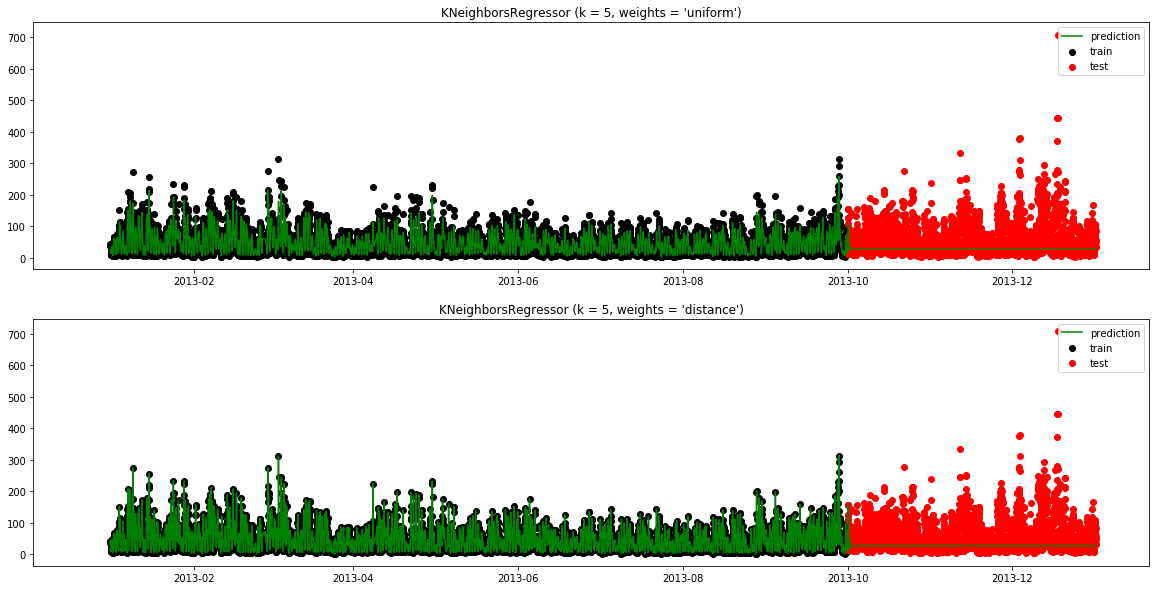

In [49]:
end = '2013-10-01'
x_train = df.loc['DESN025'].Concentration.NO[:end].dropna().index.values.reshape(-1,1)
y_train = df.loc['DESN025'].Concentration.NO[:end].dropna()

x_test = df.loc['DESN025'].Concentration.NO.dropna().index.values.reshape(-1,1)
y_test = df.loc['DESN025'].Concentration.NO.dropna()


plt.figure(figsize=(20,10))
# #############################################################################
# Fit regression model
n_neighbors = 5

for i, weights in enumerate(['uniform', 'distance']):
    knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights)
    knn_model = knn.fit(x_train, y_train)
    y_ = knn_model.predict(x_test)

    plt.subplot(2, 1, i + 1)
    plt.scatter(x_train, y_train, c='k', label='train')
    plt.scatter(df.loc['DESN025'].Concentration.NO[end:].dropna().index.values.reshape(-1,1),
                df.loc['DESN025'].Concentration.NO[end:].dropna(), c='r', label='test')
    plt.plot(x_test, y_, c='g', label='prediction')
    plt.axis('tight')
    plt.legend()
    plt.title("KNeighborsRegressor (k = %i, weights = '%s')" % (n_neighbors,
                                                                weights))
    